In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func



In [5]:
#set engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#Declare a base using 'automap_base'
Base = automap_base()

In [7]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# reflect the tables


In [8]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station



In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

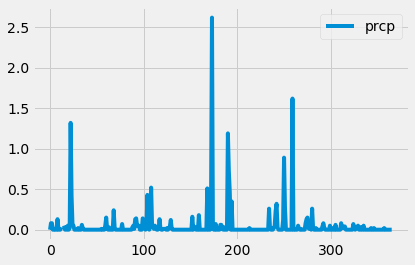

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
engine.execute("select * from measurement limit 10").fetchall()
session.query(func.count(measurement.date)).all()

# Calculate the date 1 year ago from the last data point in the database
current_year=session.query(func.max(measurement.date)).all()
current_year

# Perform a query to retrieve the data and precipitation scores
val_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= "2016-08-23").\
        filter(measurement.date <= "2017-08-23").\
        group_by(measurement.date).all()
val_data


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(val_data, columns=['date','prcp'])

# Sort the dataframe by date
df.sort_values(by='date',ascending= True) 
df.rename(columns={0:"Date",1:"Precipitation"},inplace =True)
df.set_index('date')
#df.head

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
#plt.figure(1)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [14]:
# Design a query to show how many stations are available in this dataset?
ttl_stations = session.query(func.count(station.station)).all()
ttl_stations

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?

actv_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
actv_stations

# List the stations and the counts in descending order.
actv_stations_val =actv_stations[0] 
actv_stations_val



('USC00519281', 2772)

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

all_observations = session.query(measurement.station,func.min(measurement.tobs), func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == actv_stations_val[0]).all()
all_observations



[('USC00519281', 54.0, 85.0, 71.66378066378067)]

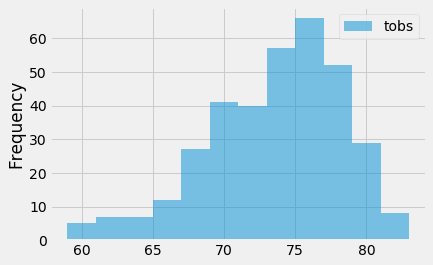

In [31]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

USC519281_plot = engine.execute('SELECT date , tobs FROM measurement WHERE station = "USC00519281" AND date > "2016-08-23"').fetchall()
USC519281_plot

usc519281_df = pd.DataFrame(USC519281_plot)
usc519281_df = usc519281_df.rename(columns={0: 'date', 1: 'tobs'})
usc519281_df.head()

usc519281_df.plot.hist(bins = 12, alpha=.5)


## Bonus Challenge Assignment

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-04-15', '2017-04-17'))

[(67.0, 71.76470588235294, 79.0)]


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
start_date ="2017-04-17" 
end_date= "2018-04-17"
def calc_temps(start_date, end_date):
    cal_btwn_dates= session.query(measurement.tobs).\
                     filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
    values_dates= [k[0] for k in cal_btwn_dates]
    avg_temp=np.mean(values_dates)
    minimum_temp=min(values_dates)
    maximum_temp=max(values_dates)
    print(avg_temp)
    print(minimum_temp)
    print(maximum_temp)
(calc_temps('2017-04-15', '2017-04-17'))

# for your trip using the previous year's data for those same dates.

start_date ="2016-04-16" 
end_date= "2017-04-17"
def calc_temps(start_date, end_date):
    cal_btwn_dates= session.query(measurement.tobs).\
                     filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
    values_dates= [k[0] for k in cal_btwn_dates]
    avg_temp=np.mean(values_dates)
    minimum_temp=min(values_dates)
    maximum_temp=max(values_dates)
    print(avg_temp)
    print(minimum_temp)
    print(maximum_temp)
(calc_temps('2016-04-15', '2016-04-17'))


71.76470588235294
67.0
79.0
73.70588235294117
66.0
80.0


([<matplotlib.axis.YTick at 0x96dc370>,
 <a list of 6 Text yticklabel objects>)

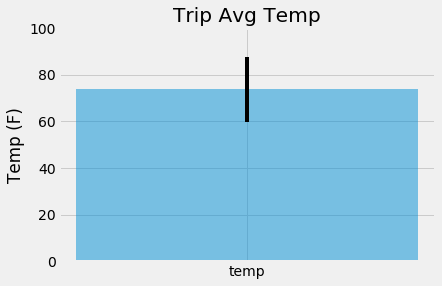

In [38]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (y error)

trip_stats = calc_temps('2016-04-15', '2016-04-17')

trip_yaxis = trip_stats[0][1]
trip_min = trip_stats[0][0]
trip_max = trip_stats[0][2]
error = [trip_max - trip_min]

plt.bar("temp", trip_yaxis, alpha=.5, align = "center", yerr = error, width=.01)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.yticks(np.arange(0, 110, 20))



In [39]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcptrip_query = engine.execute('SELECT measurement.station, name, latitude, longitude, elevation, AVG(prcp) FROM measurement \
LEFT JOIN station ON measurement.station = station.station \
WHERE date BETWEEN "2016-04-15" AND "2016-04-17" GROUP BY measurement.station ORDER BY AVG(prcp) DESC').fetchall()
prcptrip_query


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.44),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.13),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.07),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.05666666666666667),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.043333333333333335),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03)]

In [40]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("04-17")

[(65.0, 71.93103448275862, 77.0)]

In [ ]:
# calculate the daily normals for your trip


# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
